In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [20]:


# Load the image
image_path = "20241220_023954_07_24a7_3B_AnalyticMS_clip.tif"
with rasterio.open(image_path) as src:
    bands = [src.read(i) for i in range(1, src.count + 1)]


In [21]:
bands

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)]

In [22]:
flattened_bands = [band.flatten() for band in bands]
band_names = ["Blue", "Green", "Red", "NIR"]

In [18]:
flattened_bands

[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)]

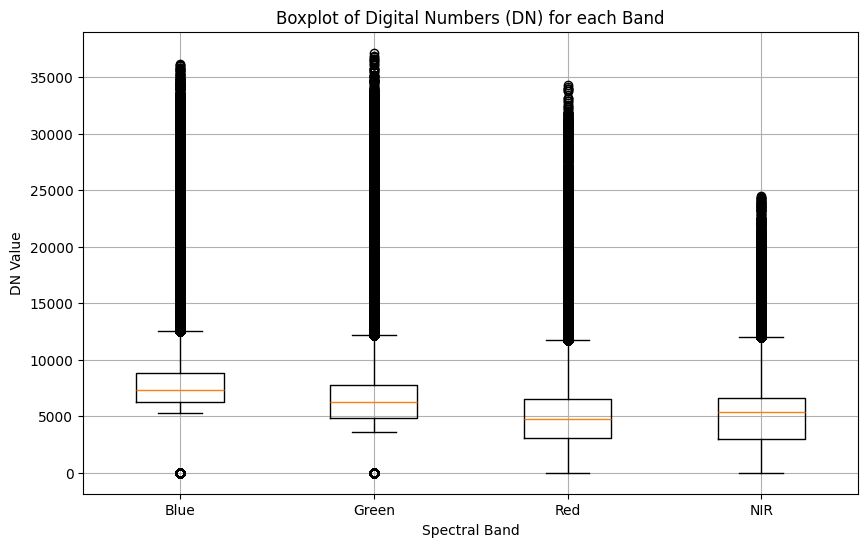

In [23]:
plt.figure(figsize=(10, 6))
plt.boxplot(flattened_bands, tick_labels= band_names)
plt.title("Boxplot of Digital Numbers (DN) for each Band")
plt.xlabel("Spectral Band")
plt.ylabel("DN Value")
plt.grid(True)
plt.show()


## DN --> Reflectance

In [24]:
# Load DN image
with rasterio.open(image_path) as src:
    profile = src.profile  # Save original metadata for later saving
    dn_bands = [src.read(i) for i in range(1, src.count + 1)]


In [25]:
# Define the scale factors for each band
scale_factors = [
    1.9014258424090274e-05,  # Blue band
    2.062244008184384e-05,  # Green band
    2.4821953798526185e-05,  # Red band
    3.928691167172263e-05   # Near-Infrared band
]

# Apply reflectance conversion for each band with its respective scale factor
reflectance_bands = [band.astype(np.float32) * scale for band, scale in zip(dn_bands, scale_factors)]

In [26]:
reflectance_path = "indonesia_planet_reflectance.tif"

with rasterio.open(
    reflectance_path,
    'w',
    driver='GTiff',
    height=reflectance_bands[0].shape[0],
    width=reflectance_bands[0].shape[1],
    count=len(reflectance_bands),
    dtype='float32',
    crs=profile['crs'],
    transform=profile['transform']
) as dst:
    for i, band in enumerate(reflectance_bands, start=1):
        dst.write(band, i)


In [27]:
flattened_reflectance = [band.flatten() for band in reflectance_bands]
band_names = ["Blue", "Green", "Red", "NIR"]

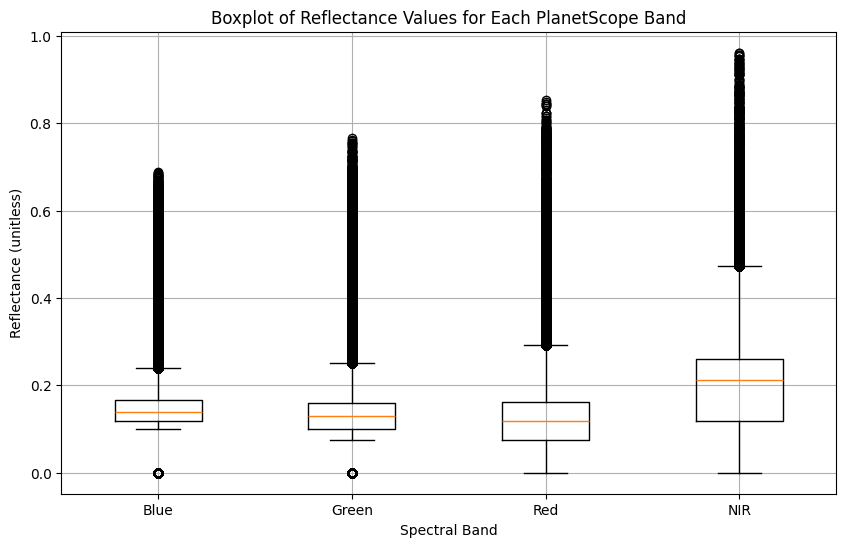

In [28]:
plt.figure(figsize=(10, 6))
plt.boxplot(flattened_reflectance, tick_labels=band_names)
plt.title("Boxplot of Reflectance Values for Each PlanetScope Band")
plt.xlabel("Spectral Band")
plt.ylabel("Reflectance (unitless)")
plt.grid(True)
plt.show()

In [30]:
import cv2

# --- Step 1: Load Reflectance Image (Bands: Blue, Green, Red) ---
with rasterio.open("indonesia_planet_reflectance.tif") as src:
    reflectance = src.read([1,2,3])  # Blue, Green, Red
    profile = src.profile


In [37]:
reflectance[1].min()

0.0

In [38]:
# Shape: (3, H, W) → Transpose to (H, W, 3)
rgb = np.transpose(reflectance, (1, 2, 0))


In [39]:
# --- Step 2: Normalize to 0–255 and Convert to uint8 ---
rgb_uint8 = np.clip(rgb * 255, 0, 255).astype(np.uint8)

In [40]:
# --- Step 3: Convert to Grayscale ---
gray = cv2.cvtColor(rgb_uint8, cv2.COLOR_RGB2GRAY)

# --- Step 4: Apply Canny Edge Detection ---
edges = cv2.Canny(gray, threshold1=50, threshold2=150)

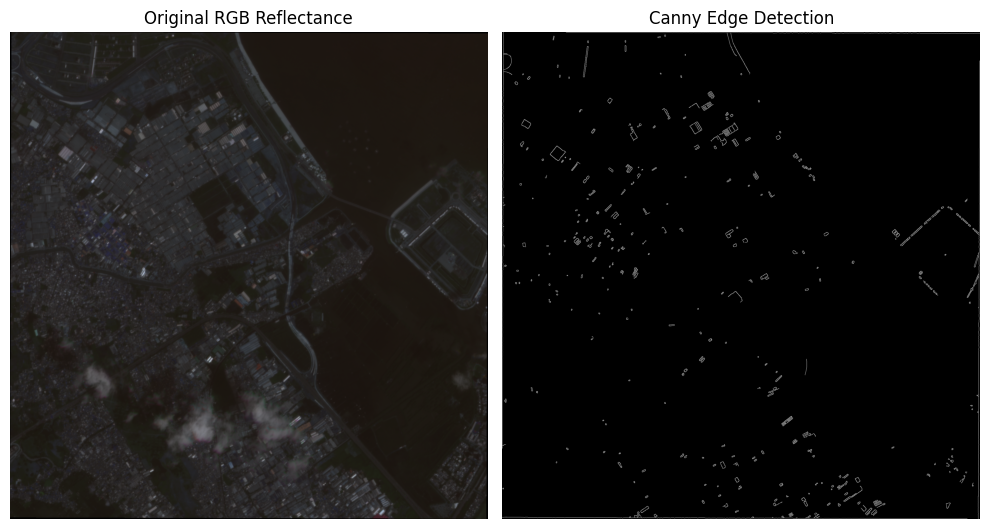

In [41]:
# --- Step 5: Plot the Result ---
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title("Original RGB Reflectance")
plt.imshow(rgb_uint8)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Canny Edge Detection")
plt.imshow(edges, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()